# CS-401: Milestone P2

This notebook aims to provide a basic primary pre-processing and analysis of datasets that we will be using. The pre-processing pipeline is divided into three parts: loading, cleaning and merging. One can have a look of this pipeline in the `preprocessing` folder. For more information, look at the `README`.

**Contents of this notebook**
- [Data Processing](#preprocessing)
  - [Loading datasets](#1-load-the-data)
  - [Cleaning](#2-basic-cleaning)
  - [Merging](#3-merging-all-datasets)
- [Basic Statistcal Analysis](#exploratory--basic-analysis)
  - [Handling Outlier](#1-outliers-removal)
  - [Missing values analysis](#2-missing-values-analysis)
  - [Key features' distribution](#3-distribution-of-key-features)
  - [Age analysis](#4-is-there-a-difference-in-age-for-women)
- [NLP Feasibility](#nlp-on-plot-summaries)


---

In [79]:
import sys

sys.path.append("./preprocessing")
sys.path.append("./analysis")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

import loader as loader
import cleaner as cleaner
import merger as merger

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

## 1. Load the data

We first start by loading datasets. CMU dataset is loaded as well as external dataset like Bechdel and TMDB dataset since these will be useful later for a more in-depth analysis.

In [50]:
# =============== LOADER =============== #
# CMU Dataset
character_df, movie_df = loader.load_CMU_dataset()
summaries_df = loader.load_summaries()

# External Dataset
bechdel_df = loader.load_bechdel_dataset()
credits_df, meta_df = loader.load_tmdb_dataset()

## 2. Basic cleaning

Here, we perform basic data cleaning operations on dataframes, such as renaming columns and converting date strings into Python datetime objects. To handle the credits dataframe, you can refer to this [function](./preprocessing/cleaner.py#clean_credit_df). Our objective is to analyze women's representation in the film industry, and to do this, we require information about the gender of the crew members for movies. We observed that this information was frequently missing, while full names were always provided. As a solution, we utilized the `genderguesser` package to predict the gender based on the first name. This approach allows us to reduce the number of ungendered samples without discarding entire rows.

In [51]:
# =============== CLEAN =============== #
# Clean datasets
movie_df = cleaner.clean_movie_df(movie_df)
bechdel_df = cleaner.clean_bechdel_df(bechdel_df)
credits_df = cleaner.clean_credit_df(credits_df, meta_df)
meta_df = cleaner.clean_metadata_df(meta_df)

Before using genderguesser:
Percentage of movies with a director's name that could not be gendered: 39.44%
Percentage of movies with a producer's name that could not be gendered: 70.92%
Percentage of movies with a writer's name that could not be gendered:   77.54%

After using genderguesser:
Percentage of movies with a director's name that could not be gendered: 6.55%
Percentage of movies with a producer's name that could not be gendered: 54.08%
Percentage of movies with a writer's name that could not be gendered:   57.74%


## 3. Merging all datasets

In [52]:
# =============== MERGE =============== #
# Merge datasets
movies = merger.merge_with_char(movie_df, character_df)
movies = merger.merge_with_summaries(movies, summaries_df)
movies = merger.merge_with_metadata(movies, meta_df)
movies = merger.merge_with_credits(movies, credits_df)

# Put the actor_name column at the beginning
movies = movies.reindex(
    columns=["actor_name"] + [col for col in movies.columns if col != "actor_name"]
)
display(movies.sample(5))

# It will be useful when we will analyze the effect of the bechdel score rating on
# the women's representation in movies
movies_with_bechdel = merger.merge_with_bechdel(movies, bechdel_df)

,actor_name,wikiID,freebaseID,movie_title,movie_release_date,movie_bo_revenue,movie_runtime,fbid_languages,fbid_countries,fbid_genres,...,popularity,vote_average,imdbid,id,director,director_gender,producer,producer_gender,writer,writer_gender
134069,Michael Constantine,10701274,/m/02qmn45,Prancer,1989-11-17,18587135.0,103.0,[English Language],[United States of America],"[Children's/Family, Animal Picture, Christmas ...",...,1.912324,5.7,0098115,24951,John D. Hancock,M,NaN,NaN,Greg Taylor,M
37108,Arben Bajraktaraj,670407,/m/031hcx,Harry Potter and the Order of the Phoenix,2007-06-28,939885929.0,137.0,[English Language],"[United States of America, United Kingdom]","[Mystery, Family Film, Fantasy Adventure, Fant...",...,21.3643,7.4,0373889,675,David Yates,M,David Heyman,M,NaN,NaN
134628,Zach Grenier,1572821,/m/05cgvt,Liebestraum,1991-09-13,NaN,109.0,[English Language],[United States of America],"[Thriller, Erotic thriller, Mystery, Drama, Su...",...,4.198128,6.2,0102299,44414,Mike Figgis,M,Eric Fellner,M,Mike Figgis,M
52267,Ann Hovey,14580095,/m/03d8jkx,Wild Boys of the Road,1933-09-22,NaN,53.0,[English Language],[United States of America],"[Drama, Adventure]",...,1.021472,6.2,0024772,50073,William A. Wellman,M,NaN,NaN,NaN,NaN
43284,Victor Argo,2547497,/m/07m9qh,Lulu on the Bridge,1998-01-01,NaN,95.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Indie, Supernatural,...",...,1.415493,5.8,0125879,42848,Paul Auster,M,NaN,NaN,Paul Auster,M


In [53]:
# Alternatively:
# You can directly load full cleaned and merged data
# movies = pd.read_pickle("./data/Processed/movies_cleaned.pkl")

# Exploratory & Basic Analysis

Now, let's explore and try to understand the data. 

## 1. Outliers removal

In [54]:
# Import our visualization tools
import visualizer as viz

In [55]:
movies.drop(columns=["wikiID"]).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,8.174700e+04,167861.000000,170127.000000,77404.000000,125455.000000,170127.000000
mean,7.591529e+07,105.253108,1988.899410,1.785753,38.336384,6.029420
std,1.491195e+08,26.051526,21.754745,3.765668,14.353359,1.220987
min,1.047400e+04,0.566667,1893.000000,0.610000,-81.000000,0.000000
25%,5.781045e+06,91.000000,1977.000000,1.680000,28.000000,5.500000
50%,2.257359e+07,101.000000,1997.000000,1.760000,37.000000,6.200000
75%,7.837120e+07,115.000000,2006.000000,1.830000,47.000000,6.800000
max,2.782275e+09,1003.000000,2014.000000,510.000000,96.000000,10.000000


As one can see, there are outliers and dirty samples in the data. We will remove them in the next cell, outliers will be remove by quantile method (see [here](./preprocessing/cleaner.py#clean_remove_outlier))

In [56]:
movies = cleaner.clean_movies_ranges(movies)
movies = cleaner.clean_remove_outlier(
    movies, method="quantile", name="actor_height_meters"
)
movies = cleaner.clean_remove_outlier(movies, method="quantile", name="movie_runtime")

movies.drop(columns=["wikiID"]).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,4.254300e+04,71601.000000,71601.000000,71601.000000,67696.000000,71601.000000
mean,7.767795e+07,103.272821,1991.414394,1.756210,37.778658,5.959284
std,1.334172e+08,15.544283,19.578993,0.100157,13.744698,1.133186
min,1.263600e+04,60.000000,1914.000000,1.470000,0.000000,0.000000
25%,7.175592e+06,92.000000,1984.000000,1.680000,28.000000,5.500000
50%,2.696019e+07,101.000000,1998.000000,1.760000,36.000000,6.100000
75%,8.832349e+07,113.000000,2006.000000,1.830000,46.000000,6.700000
max,1.511758e+09,148.000000,2012.000000,2.050000,95.000000,10.000000


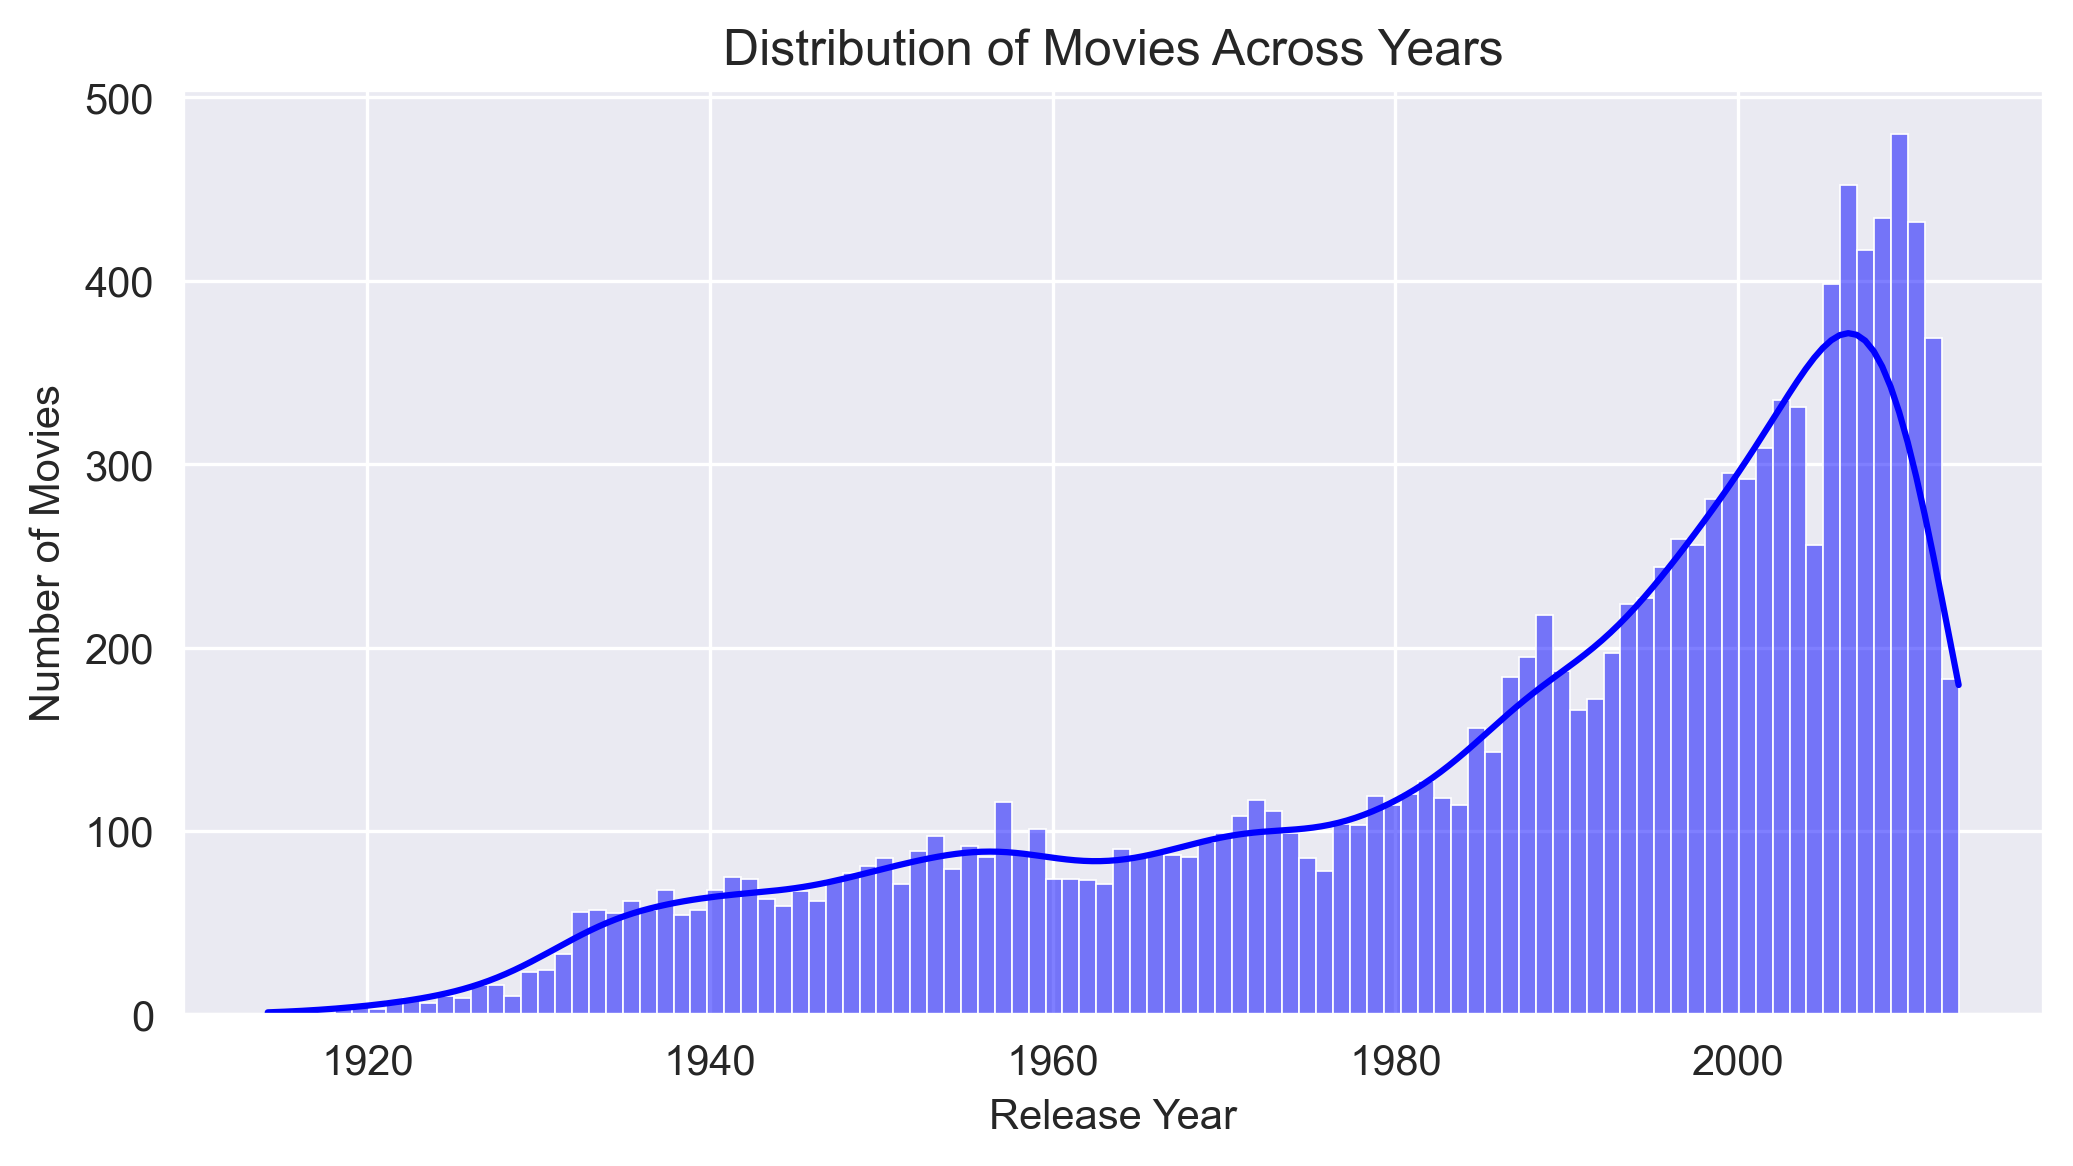

Total number of movies:  12779
Mean number of movies per year: 132


In [57]:
viz.visualize_year_distribution(movies)

With this cleaning, we are ensure to have roughly between 50 and more than 100 movies per year. 

## 2. Missing values analysis

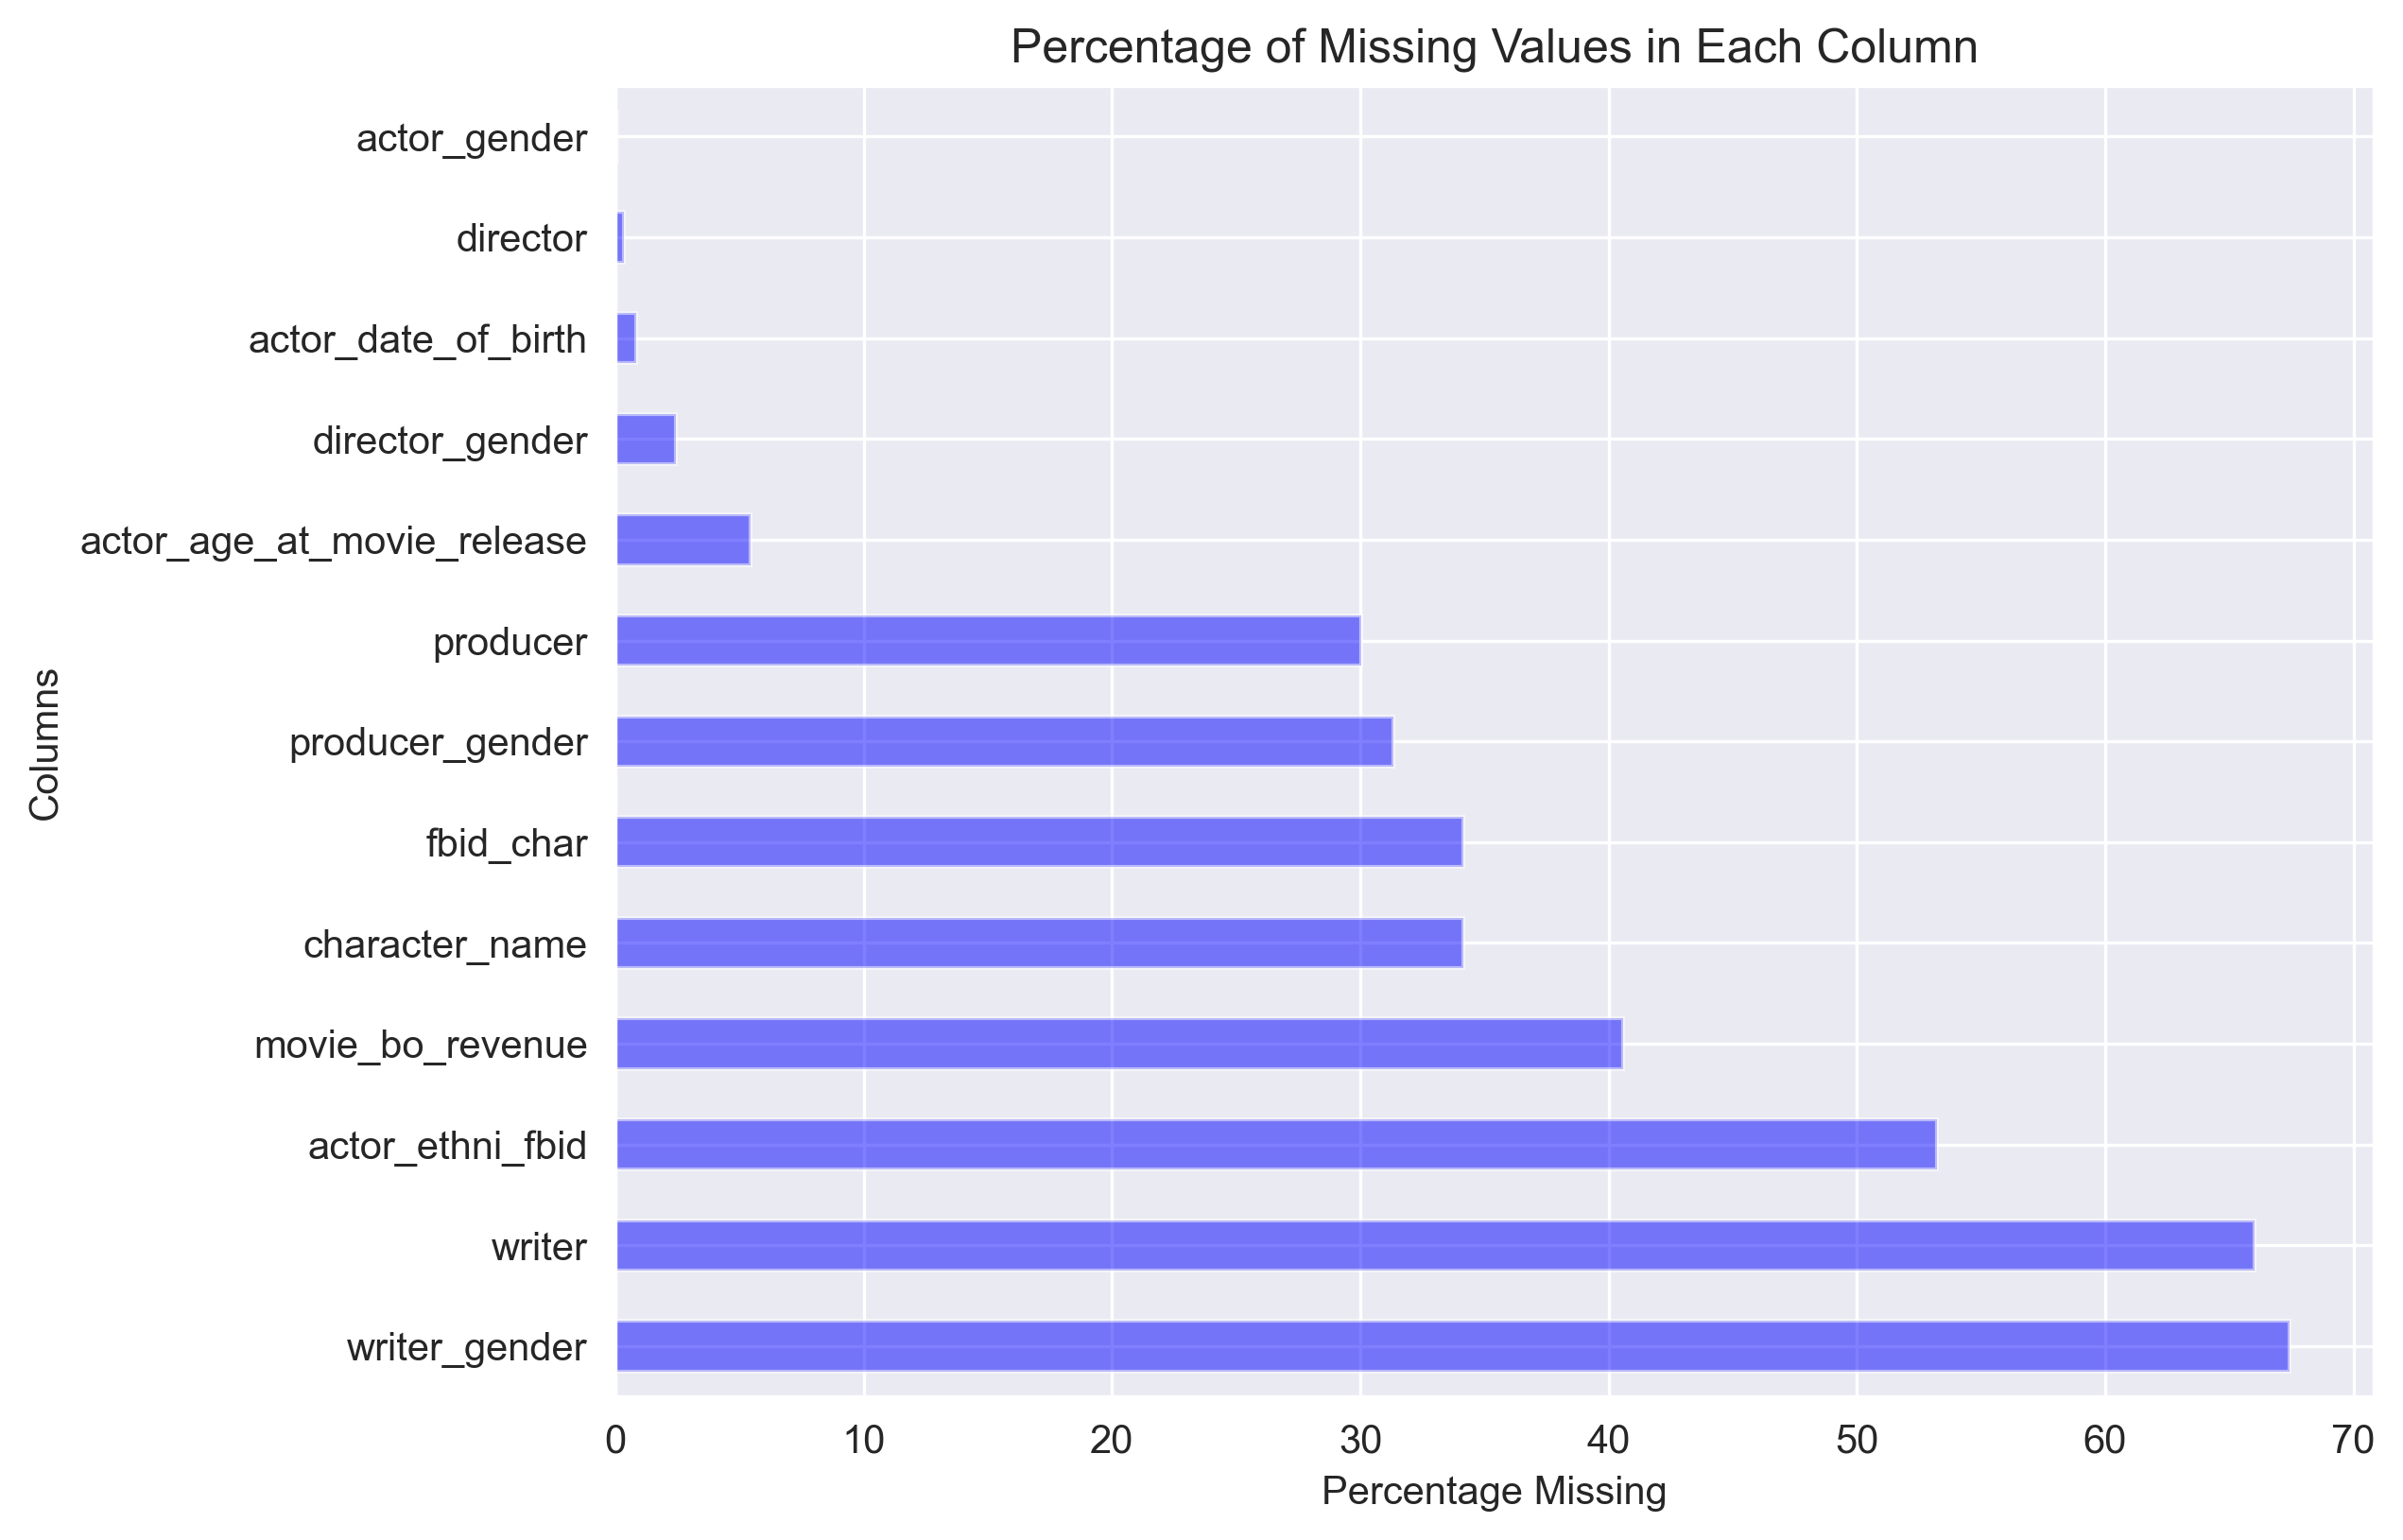

In [58]:
viz.visualize_missing_values(movies)

<div align="justify">

Based on the previous plot, it is evident that there are numerous missing values for the `writer` and `writer_gender` features. Given their limited usability due to this, it's necessary to remove them. Additionally, the `actor_ethni_fbid` feature, which would not have been utilized regardless, should also be dropped.

This correspond to dropping colums with more than 50% of missing values.

</div>

In [59]:
movies = cleaner.clean_missing_values_by_dropping(
    movies, to_drop=["writer", "writer_gender", "actor_ethni_fbid"]
)
display(movies.sample(2))

,actor_name,wikiID,freebaseID,movie_title,movie_release_date,movie_bo_revenue,movie_runtime,fbid_languages,fbid_countries,fbid_genres,...,summary,budget,popularity,vote_average,imdbid,id,director,director_gender,producer,producer_gender
36495,Mary Goggin,35244336,/m/0fq9_5t,The Trouble with Bliss,2011-03-23,13093.0,97.0,[English Language],[United States of America],"[Comedy film, Drama]",...,"Morris Bliss, aged 35, wants to travel but he ...",0,7.453375,4.0,1483756,90122,David Weaver,M,András Hámori,M
71997,James Whitmore,4362550,/m/0bz7ms,Nuts,1987-11-20,30950002.0,116.0,[English Language],[United States of America],"[Crime Fiction, Musical, Drama, Courtroom Drama]",...,When call girl Claudia Draper kills client All...,25000000,2.258245,6.0,0093660,40634,Martin Ritt,M,Barbra Streisand,F


## 3. Distribution of Key Features

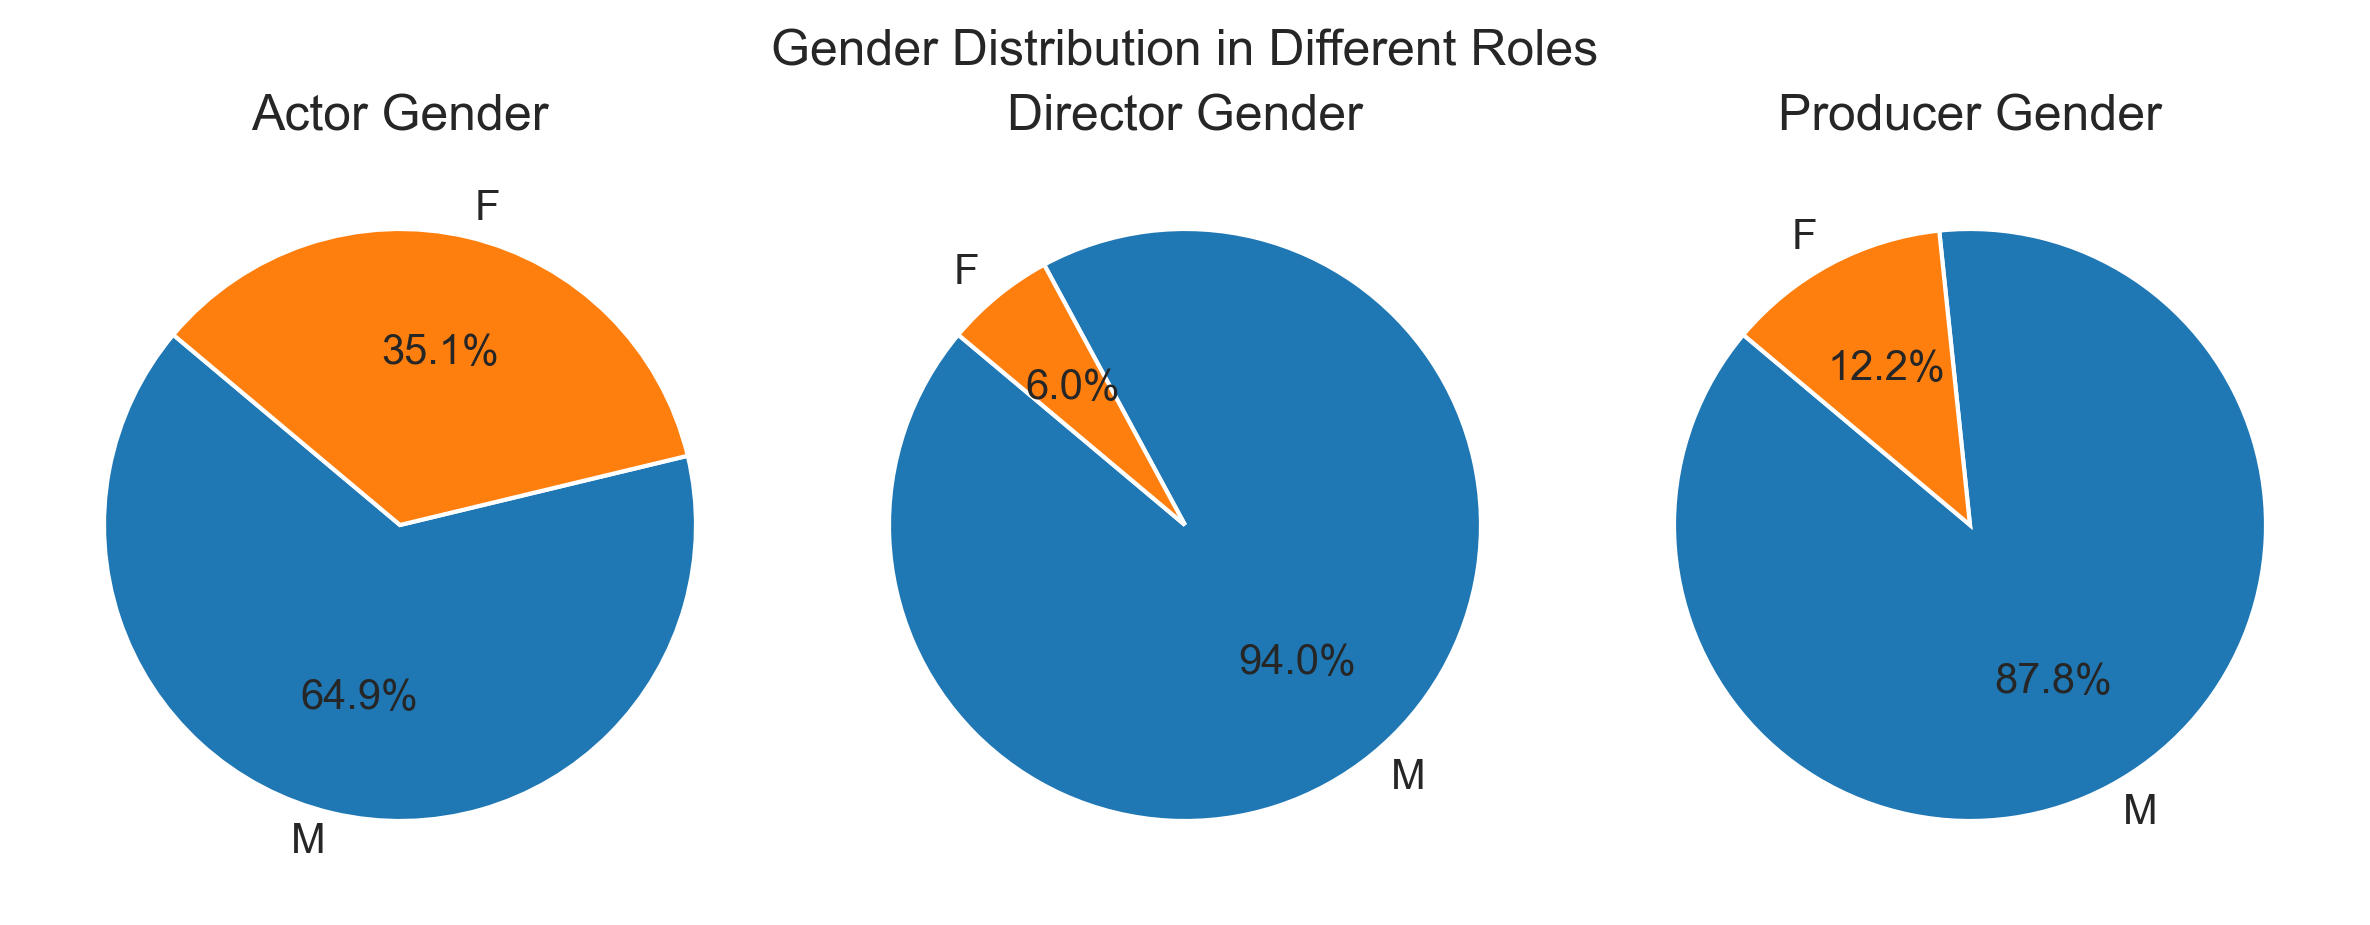

In [62]:
viz.visualize_gender_distribution(movies)

**Conclusion**: One can clearly see that women are underrepresented both in front of the camera and behind the scenes.

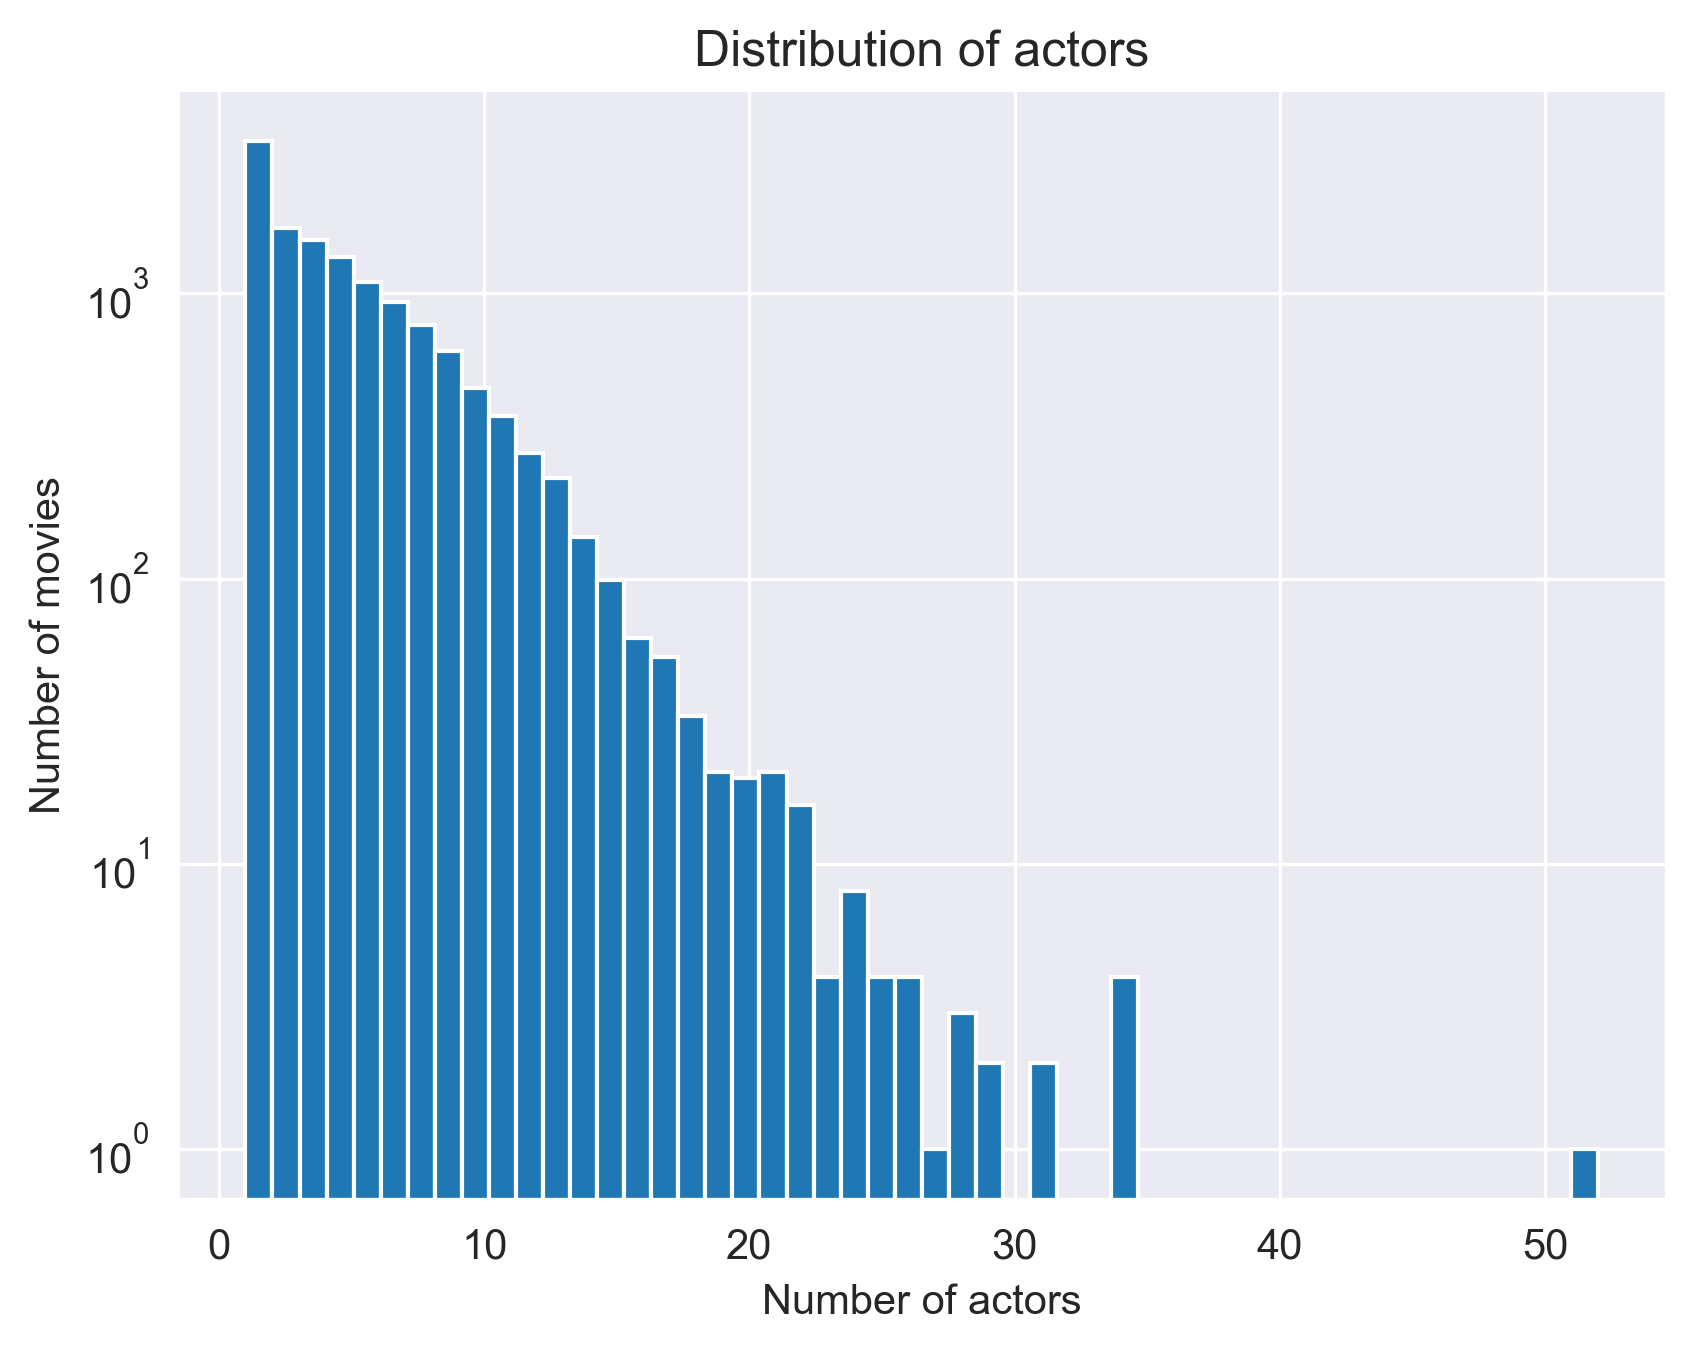

In [66]:
viz.visualize_actors_distribution(movies)

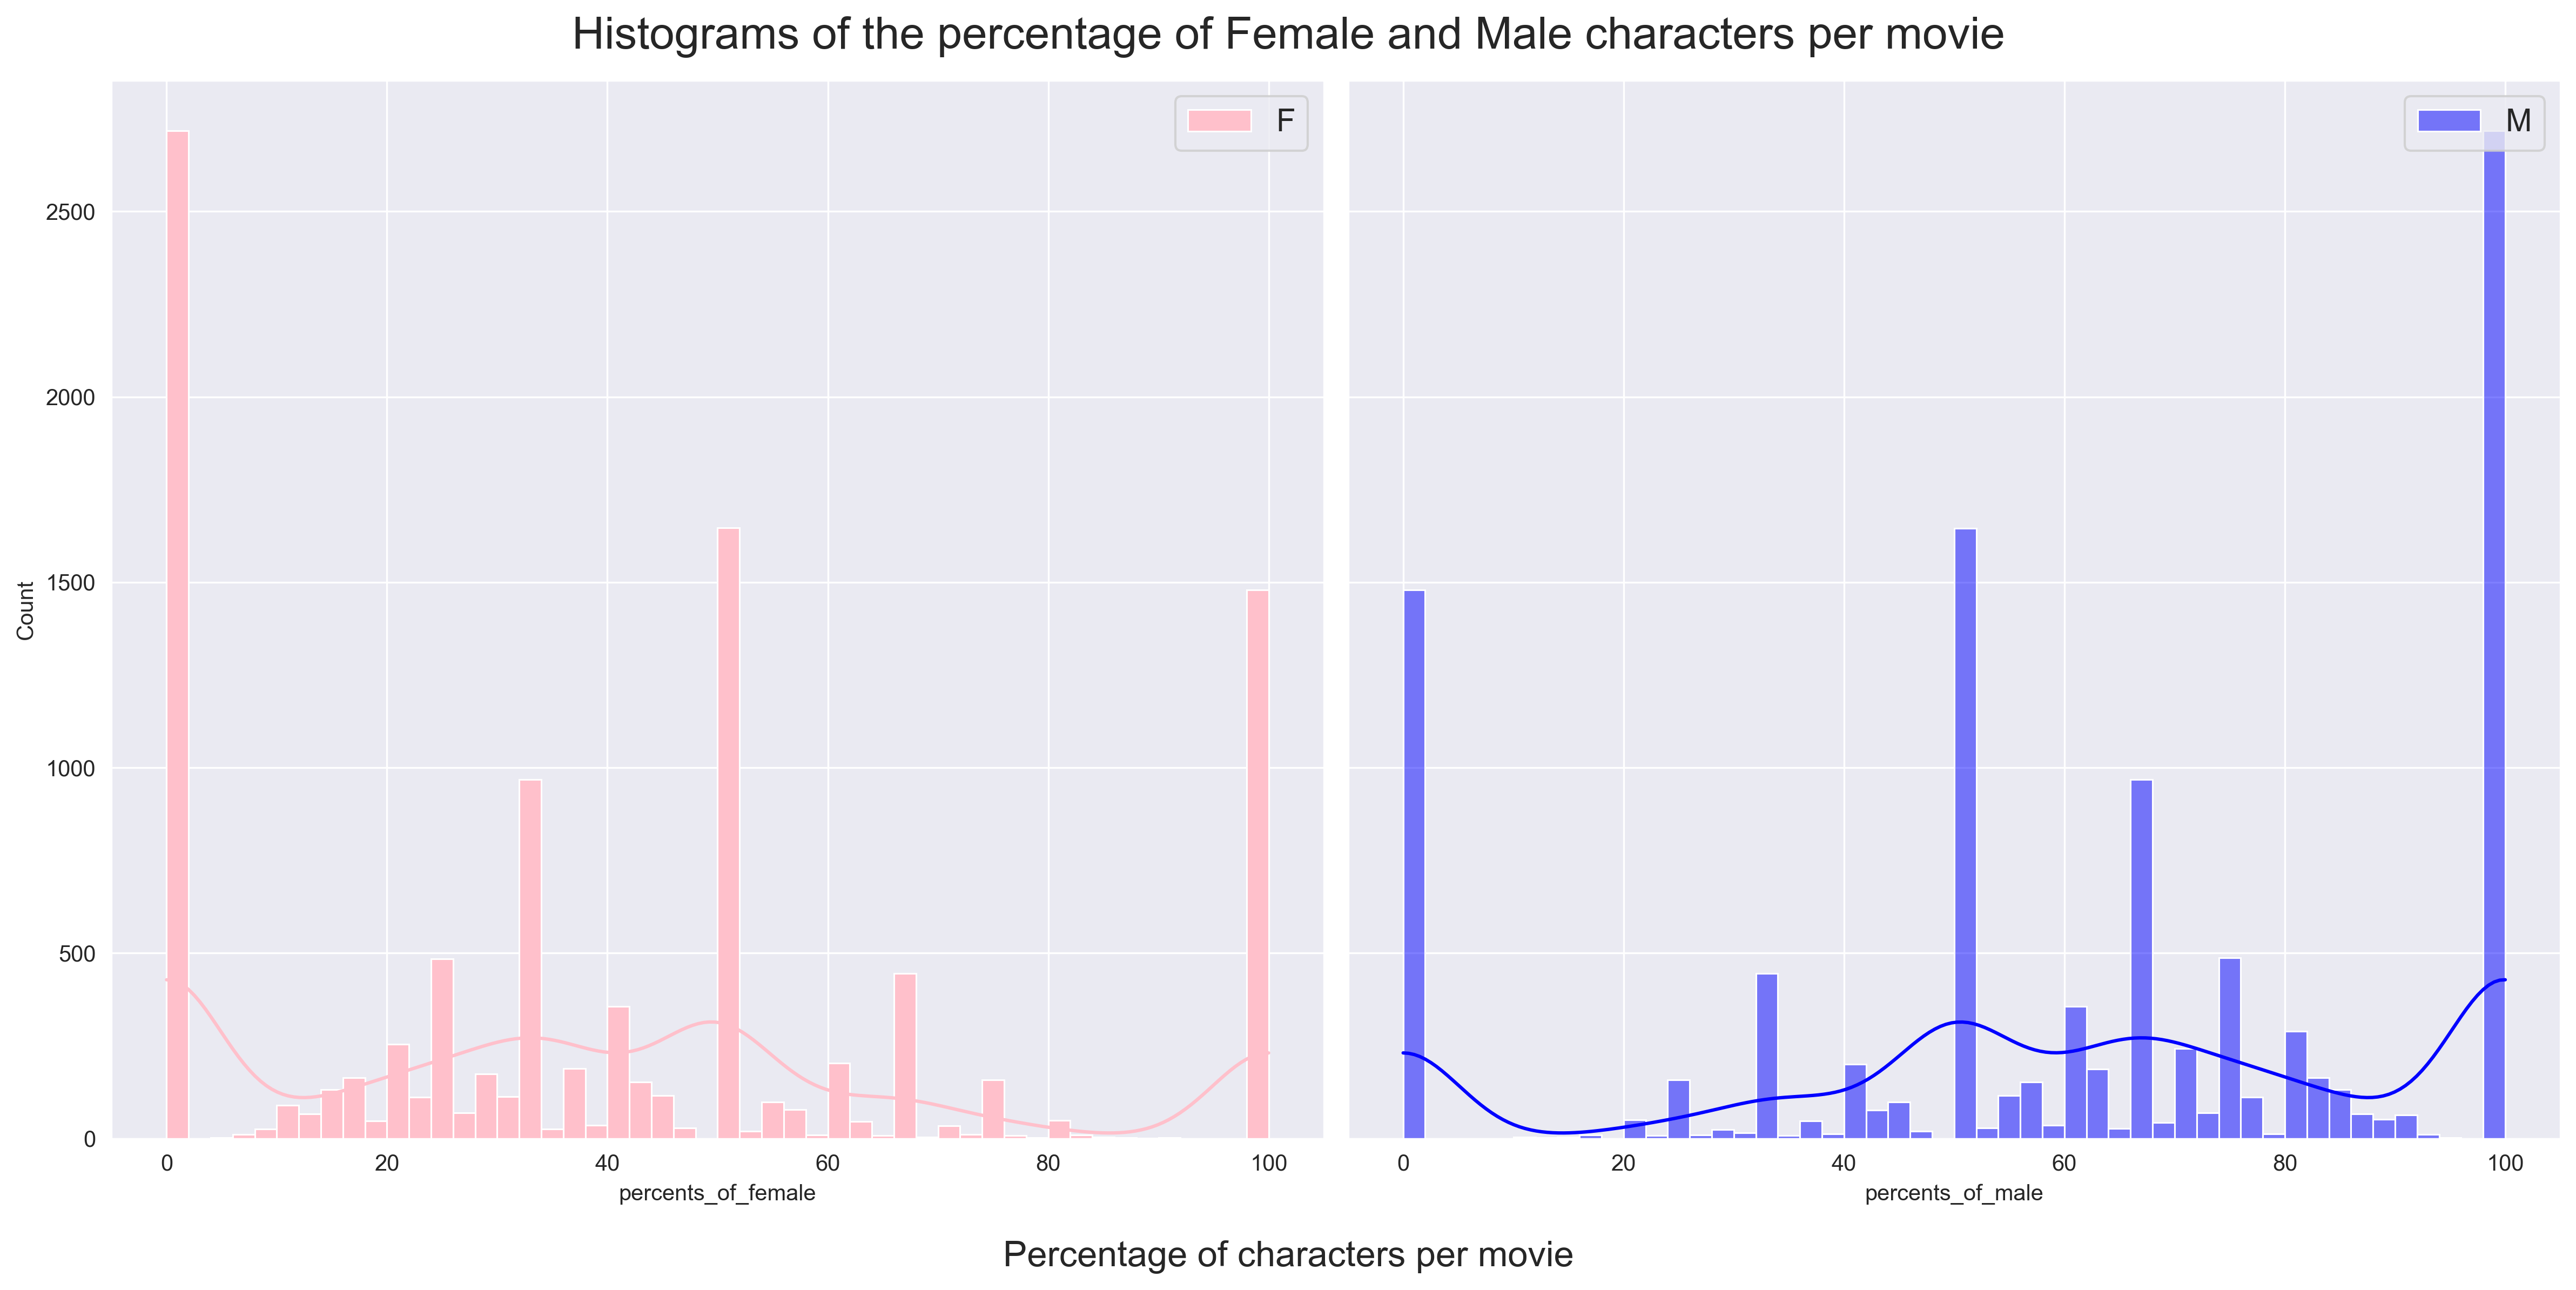

In [ ]:
male_female_prop = viz.visualize_gender_proportion_repartition(movies)

In [ ]:
movies_gender_prop = pd.merge(movies, male_female_prop, on=["wikiID", "year"])
movies_gender_prop.drop_duplicates(subset=["movie_title"], inplace=True)

# Compute Pearson Correlation between the popularity and the % of female actresses
print(
    stats.pearsonr(
        movies_gender_prop["percents_of_female"].astype(float),
        movies_gender_prop["popularity"].astype(float),
    )
)

# Compute Pearson Correlation between the vote average and the % of female actresses
print(
    stats.pearsonr(
        movies_gender_prop["percents_of_female"], movies_gender_prop["vote_average"]
    )
)

PearsonRResult(statistic=-0.10826110104710499, pvalue=2.4719681052407855e-28)
PearsonRResult(statistic=-0.09131447861286136, pvalue=1.362114952101395e-20)


**Conclusion** : Since the $p$-value is low, the result is significative and one can deduce a negative correlation between the proportion of female and the success of a movie. This is already useful to know since it will be used in milestone P3

## 4. Is there a difference in age for Women ?

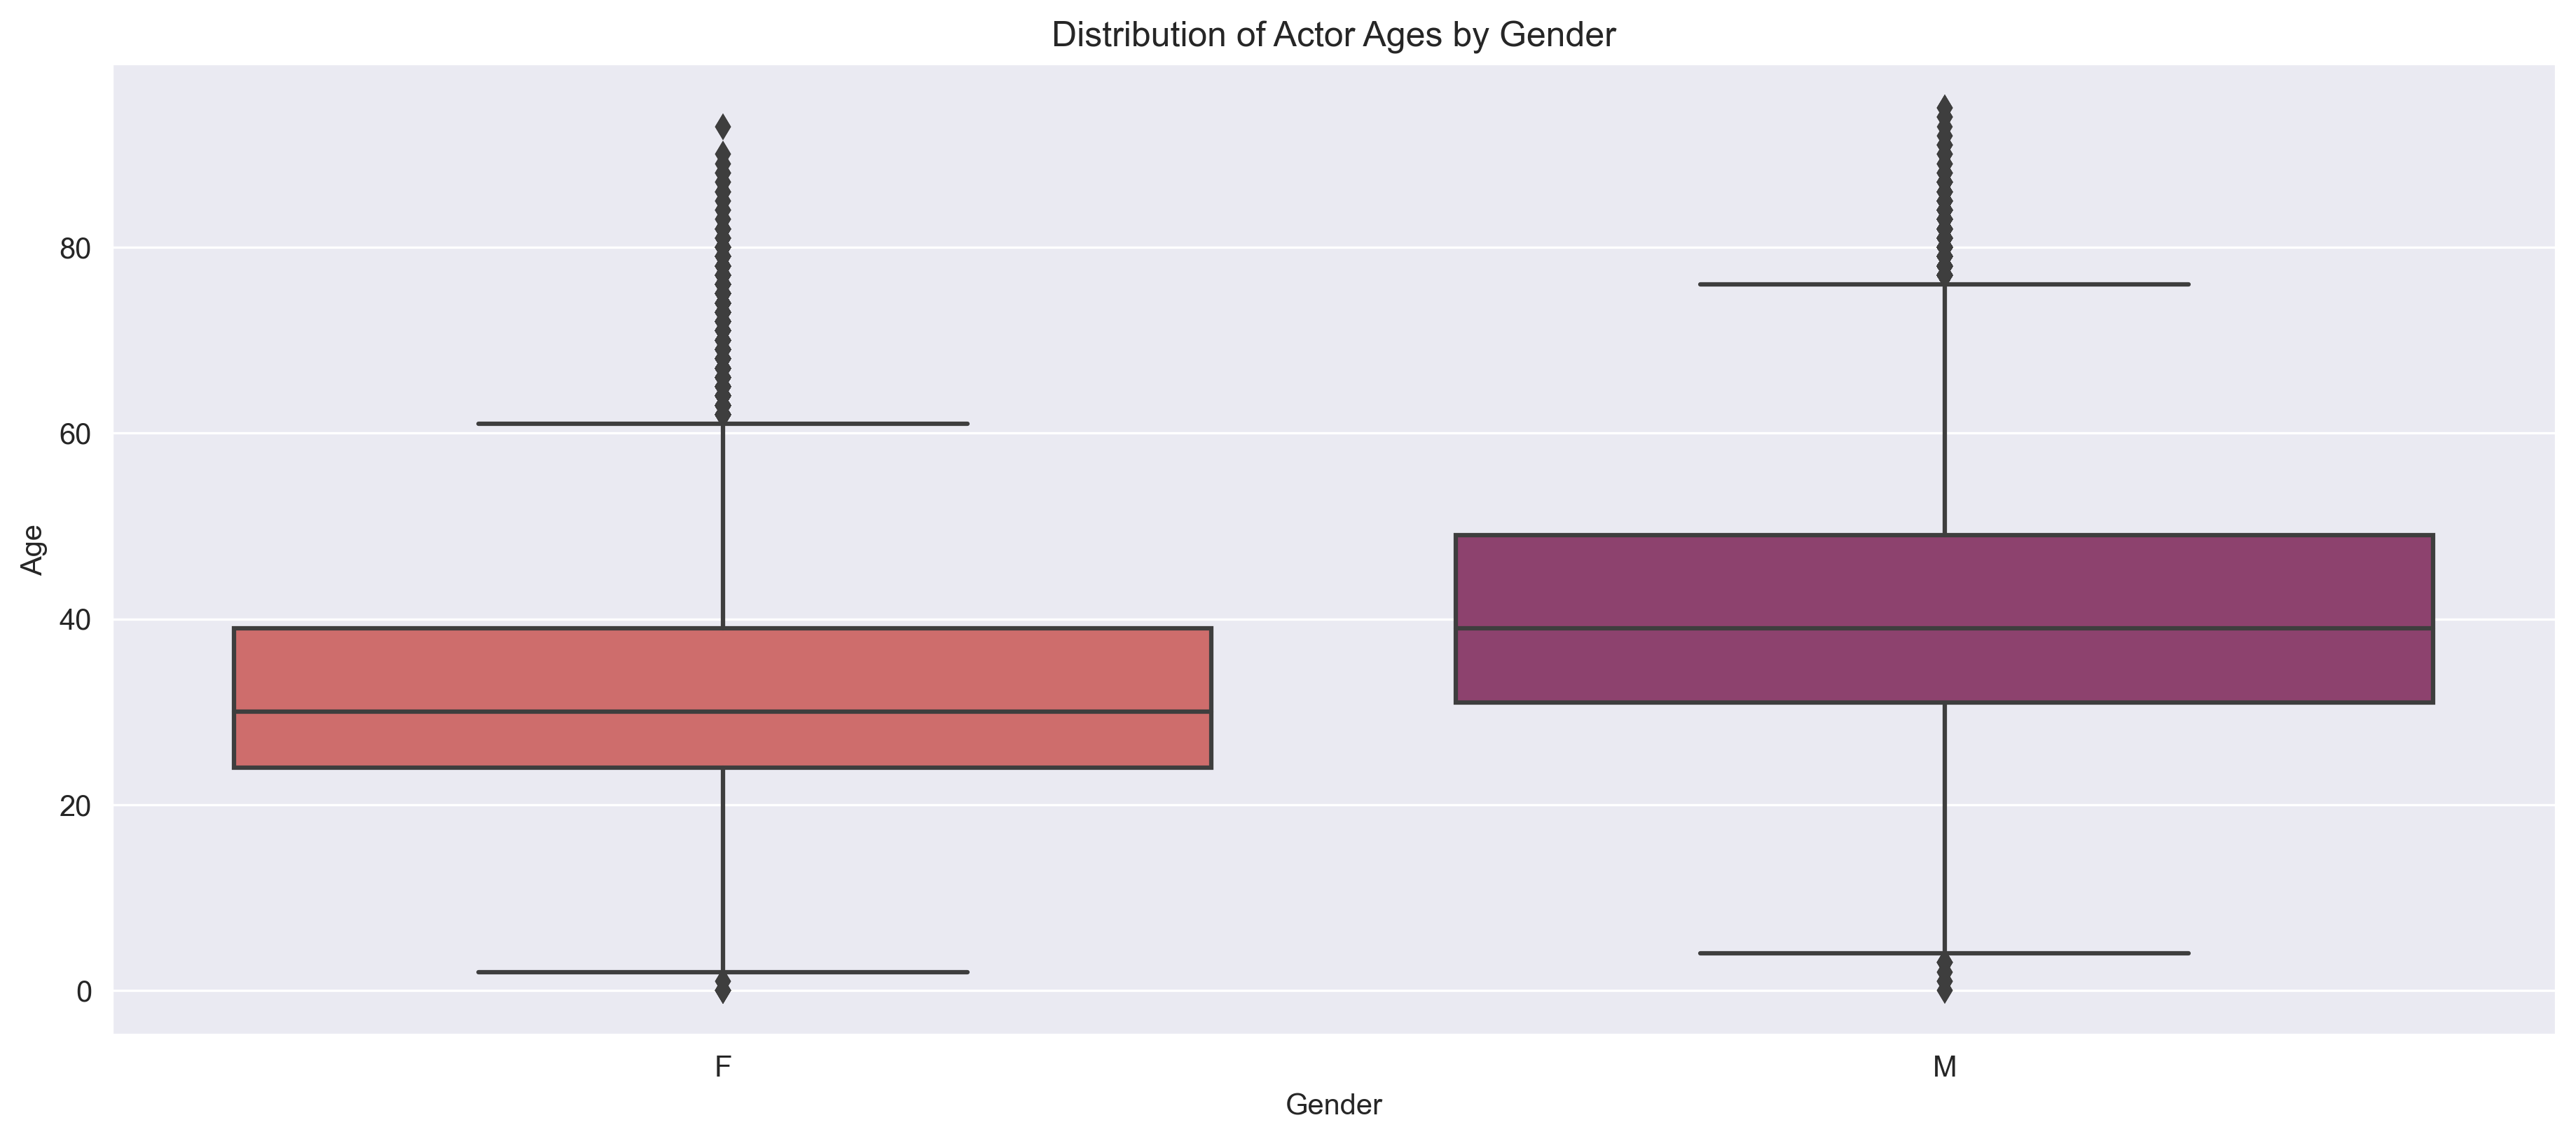

In [83]:
viz.visualize_age_distribution_by_gender(movies)

We can observe that men are older in average. Let's make a $t$-test to see if the difference is significant.

In [86]:
women_age = movies[movies["actor_gender"] == "F"]["actor_age_at_movie_release"]
men_age = movies[movies["actor_gender"] == "M"]["actor_age_at_movie_release"]
# T-test to determine if the difference in age between men and women is statistically significant
print(stats.ttest_ind(women_age, men_age, nan_policy="omit"))

Ttest_indResult(statistic=-73.08335051739951, pvalue=0.0)


TODO: Rewrite 

pvalue < 0.05 -> significant 
stat < 0 => women are younger than men

# NLP on Plot Summaries

**Break down of the ideas for the NLP analysis**
- 1. Preprocessing of the plot summaries
    - clean the texts, remove ponctuation etc
    - tokenize the plot summarize as it will be helpful for subsequent analysis
    - add some additional information to the dataframe that can be usefull later like the length of summary
    - create 2 set of plot summary, one for the movies that pass the bechdel test, and the other for the rest
- 2. Word frequency analysis
    - occurrence of gender specific word comparison
    - some statistical analysis
    
- 3. Sentiment analysis 



## Preprocessing of the texts and cleaning

In [ ]:
df_summaries = loader.load_summaries()
df_summaries = (
    pd.merge(df_summaries, movies[["wikiID", "movie_title"]], on="wikiID", how="right")
    .drop_duplicates()
    .dropna(subset=["movie_title"])
)

In [ ]:
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords

# Here we clean the text representation of each summary to make it easier to analyse

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


def clean_text(text):
    text = text.lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub(r"\w*\d\w*", "", text)
    return " ".join(word for word in text.split() if word not in stop_words)


df_summaries["summary"] = df_summaries["summary"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/francoisdumoncel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_summaries.head()

,wikiID,summary,movie_title
0,975900,set second half century film depicts mars plan...,Ghosts of Mars
9,171005,plotdateact finally negotiations made henry na...,Henry V
21,77856,film opens mary poppins perched cloud high lon...,Mary Poppins
29,21926710,jimmy hiroshi watanabe loves dinosaurs sleeps ...,White on Rice
33,156558,young named jody lives mother juanita amg movi...,Baby Boy


### tokenization


In [ ]:
from nltk.tokenize import word_tokenize

# Simply tokenize the corpus so we can access each word separatly
nltk.download("punkt")
df_summaries["tokens"] = df_summaries["summary"].apply(word_tokenize)
df_summaries["len"] = df_summaries["summary"].apply(lambda x: len(x))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/francoisdumoncel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## creation of the 2 dataframe for comparison


In [ ]:
summary_bechdel_df = pd.merge(bechdel_df, df_summaries, on="movie_title").drop(
    ["imdbid", "year", "summary"], axis=1
)

# DataFrame of movies that pass the Bechdel test (rating of 3)
pass_bechdel_df = summary_bechdel_df[summary_bechdel_df["bechdel_rating"] == 3].drop(
    "bechdel_rating", axis=1
)

# DataFrame of movies that don't pass the Bechdel test (rating of 2 or less)
dont_pass_bechdel_df = summary_bechdel_df[
    summary_bechdel_df["bechdel_rating"] <= 2
].drop("bechdel_rating", axis=1)

In [ ]:
pass_bechdel_df.reset_index(drop=True)

,movie_title,wikiID,tokens,len
0,Cinderella,399402,"[cinderella, muchloved, child, widowed, aristo...",2752
1,Cinderella,1303197,"[village, square, herald, proclaims, prince, g...",2039
2,Cinderella,399402,"[cinderella, muchloved, child, widowed, aristo...",2752
3,Cinderella,1303197,"[village, square, herald, proclaims, prince, g...",2039
4,Cinderella,399402,"[cinderella, muchloved, child, widowed, aristo...",2752
...,...,...,...,...
1907,Flashback,2135286,"[huey, walker, hippie, former, new, left, radi...",381
1908,Fresh,1610563,"[michael, nicknamed, fresh, portrayed, sean, n...",247
1909,Look Both Ways,2701438,"[film, charts, stories, several, people, hot, ...",943
1910,Smile,1605120,"[katie, teenage, girl, malibu, california, fin...",582


In [ ]:
dont_pass_bechdel_df.reset_index(drop=True)

,movie_title,wikiID,tokens,len
0,Bluebeard,6552222,"[paris, frightened, murders, attributed, blueb...",1707
1,Cleopatra,6306820,"[bc, cleopatra, vies, brother, ptolemy, contro...",1853
2,Cleopatra,13269570,"[cleopatra, aged, school, teacher, struggles, ...",315
3,Cleopatra,6306820,"[bc, cleopatra, vies, brother, ptolemy, contro...",1853
4,Cleopatra,13269570,"[cleopatra, aged, school, teacher, struggles, ...",315
...,...,...,...,...
1545,Limbo,3024499,"[film, set, fictional, port, henry, alaska, to...",2044
1546,Pig,33243299,"[expand, section, man, wakes, alone, middle, d...",377
1547,Nightmare Alley,2006189,"[movie, follows, rise, fall, con, man, —, stor...",1920
1548,Athena,1978686,"[conservative, lawyer, adam, calhorn, shaw, ho...",2043


## word frequency

In [ ]:
from collections import Counter

word_counts = Counter(word for tokens in df_summaries["tokens"] for word in tokens)
most_common_words = word_counts.most_common(20)

In [ ]:
most_common_words

[('one', 13248),
 ('back', 10866),
 ('two', 9498),
 ('tells', 9488),
 ('new', 8287),
 ('home', 7578),
 ('find', 7452),
 ('later', 7426),
 ('man', 7334),
 ('father', 7214),
 ('time', 7199),
 ('film', 7112),
 ('finds', 7092),
 ('get', 7085),
 ('house', 7024),
 ('however', 6949),
 ('also', 6635),
 ('life', 6562),
 ('go', 6473),
 ('goes', 6164)]

Here the idea is to count the occurence of some gender specific word in each summary 

In [ ]:
# List of gender-specific words
female_words = [
    "she",
    "her",
    "hers",
    "woman",
    "women",
    "female",
    "girl",
    "girls",
    "lady",
    "ladies",
    "daughter",
    "daughters",
    "mother",
    "mothers",
    "mom",
    "moms",
    "mum",
    "mums",
    "wife",
    "wives",
    "girlfriend",
    "girlfriends",
    "sister",
    "sisters",
    "aunt",
    "aunts",
    "grandmother",
    "grandmothers",
    "granddaughter",
    "granddaughters",
    "niece",
    "nieces",
    "female",
    "feminine",
    "her",
    "herself",
    "madam",
    "maiden",
    "matriarch",
    "queen",
    "princess",
    "bride",
]
male_words = [
    "he",
    "him",
    "his",
    "man",
    "men",
    "male",
    "boy",
    "boys",
    "guy",
    "guys",
    "gentleman",
    "gentlemen",
    "son",
    "sons",
    "father",
    "fathers",
    "dad",
    "dads",
    "husband",
    "husbands",
    "boyfriend",
    "boyfriends",
    "brother",
    "brothers",
    "uncle",
    "uncles",
    "grandfather",
    "grandfathers",
    "grandson",
    "grandsons",
    "nephew",
    "nephews",
    "male",
    "masculine",
    "himself",
    "sir",
    "lad",
    "patriarch",
    "king",
    "prince",
    "groom",
]

# Count occurrences in summaries
dont_pass_bechdel_df["F word freq"] = dont_pass_bechdel_df["tokens"].apply(
    lambda x: sum(word in x for word in female_words) / len(x)
)
dont_pass_bechdel_df["M word freq"] = dont_pass_bechdel_df["tokens"].apply(
    lambda x: sum(word in x for word in male_words) / len(x)
)

dont_pass_bechdel_df["F word count"] = dont_pass_bechdel_df["tokens"].apply(
    lambda x: sum(word in x for word in female_words)
)
dont_pass_bechdel_df["M word count"] = dont_pass_bechdel_df["tokens"].apply(
    lambda x: sum(word in x for word in male_words)
)

pass_bechdel_df["F word freq"] = pass_bechdel_df["tokens"].apply(
    lambda x: sum(word in x for word in female_words) / len(x)
)
pass_bechdel_df["M word freq"] = pass_bechdel_df["tokens"].apply(
    lambda x: sum(word in x for word in male_words) / len(x)
)

pass_bechdel_df["F word count"] = pass_bechdel_df["tokens"].apply(
    lambda x: sum(word in x for word in female_words)
)
pass_bechdel_df["M word count"] = pass_bechdel_df["tokens"].apply(
    lambda x: sum(word in x for word in male_words)
)

In [ ]:
pass_bechdel_df.head()

,movie_title,wikiID,tokens,len,F word freq,M word freq,F word count,M word count
0,Cinderella,399402,"[cinderella, muchloved, child, widowed, aristo...",2752,0.021739,0.01087,8,4
1,Cinderella,1303197,"[village, square, herald, proclaims, prince, g...",2039,0.025830,0.01476,7,4
2,Cinderella,399402,"[cinderella, muchloved, child, widowed, aristo...",2752,0.021739,0.01087,8,4
3,Cinderella,1303197,"[village, square, herald, proclaims, prince, g...",2039,0.025830,0.01476,7,4
4,Cinderella,399402,"[cinderella, muchloved, child, widowed, aristo...",2752,0.021739,0.01087,8,4


## Statistical analysis 
Null Hypothesis (H0)
"The frequency of female-specific vocabulary in movie summaries is the same for movies that pass the Bechdel test and for those that do not."

Alternative Hypothesis (H1)
"The frequency of female-specific vocabulary in movie summaries is higher in movies that pass the Bechdel test compared to those that do not."

T-Statistic: 11.467174462176411
P-Value: 6.645443317226982e-30


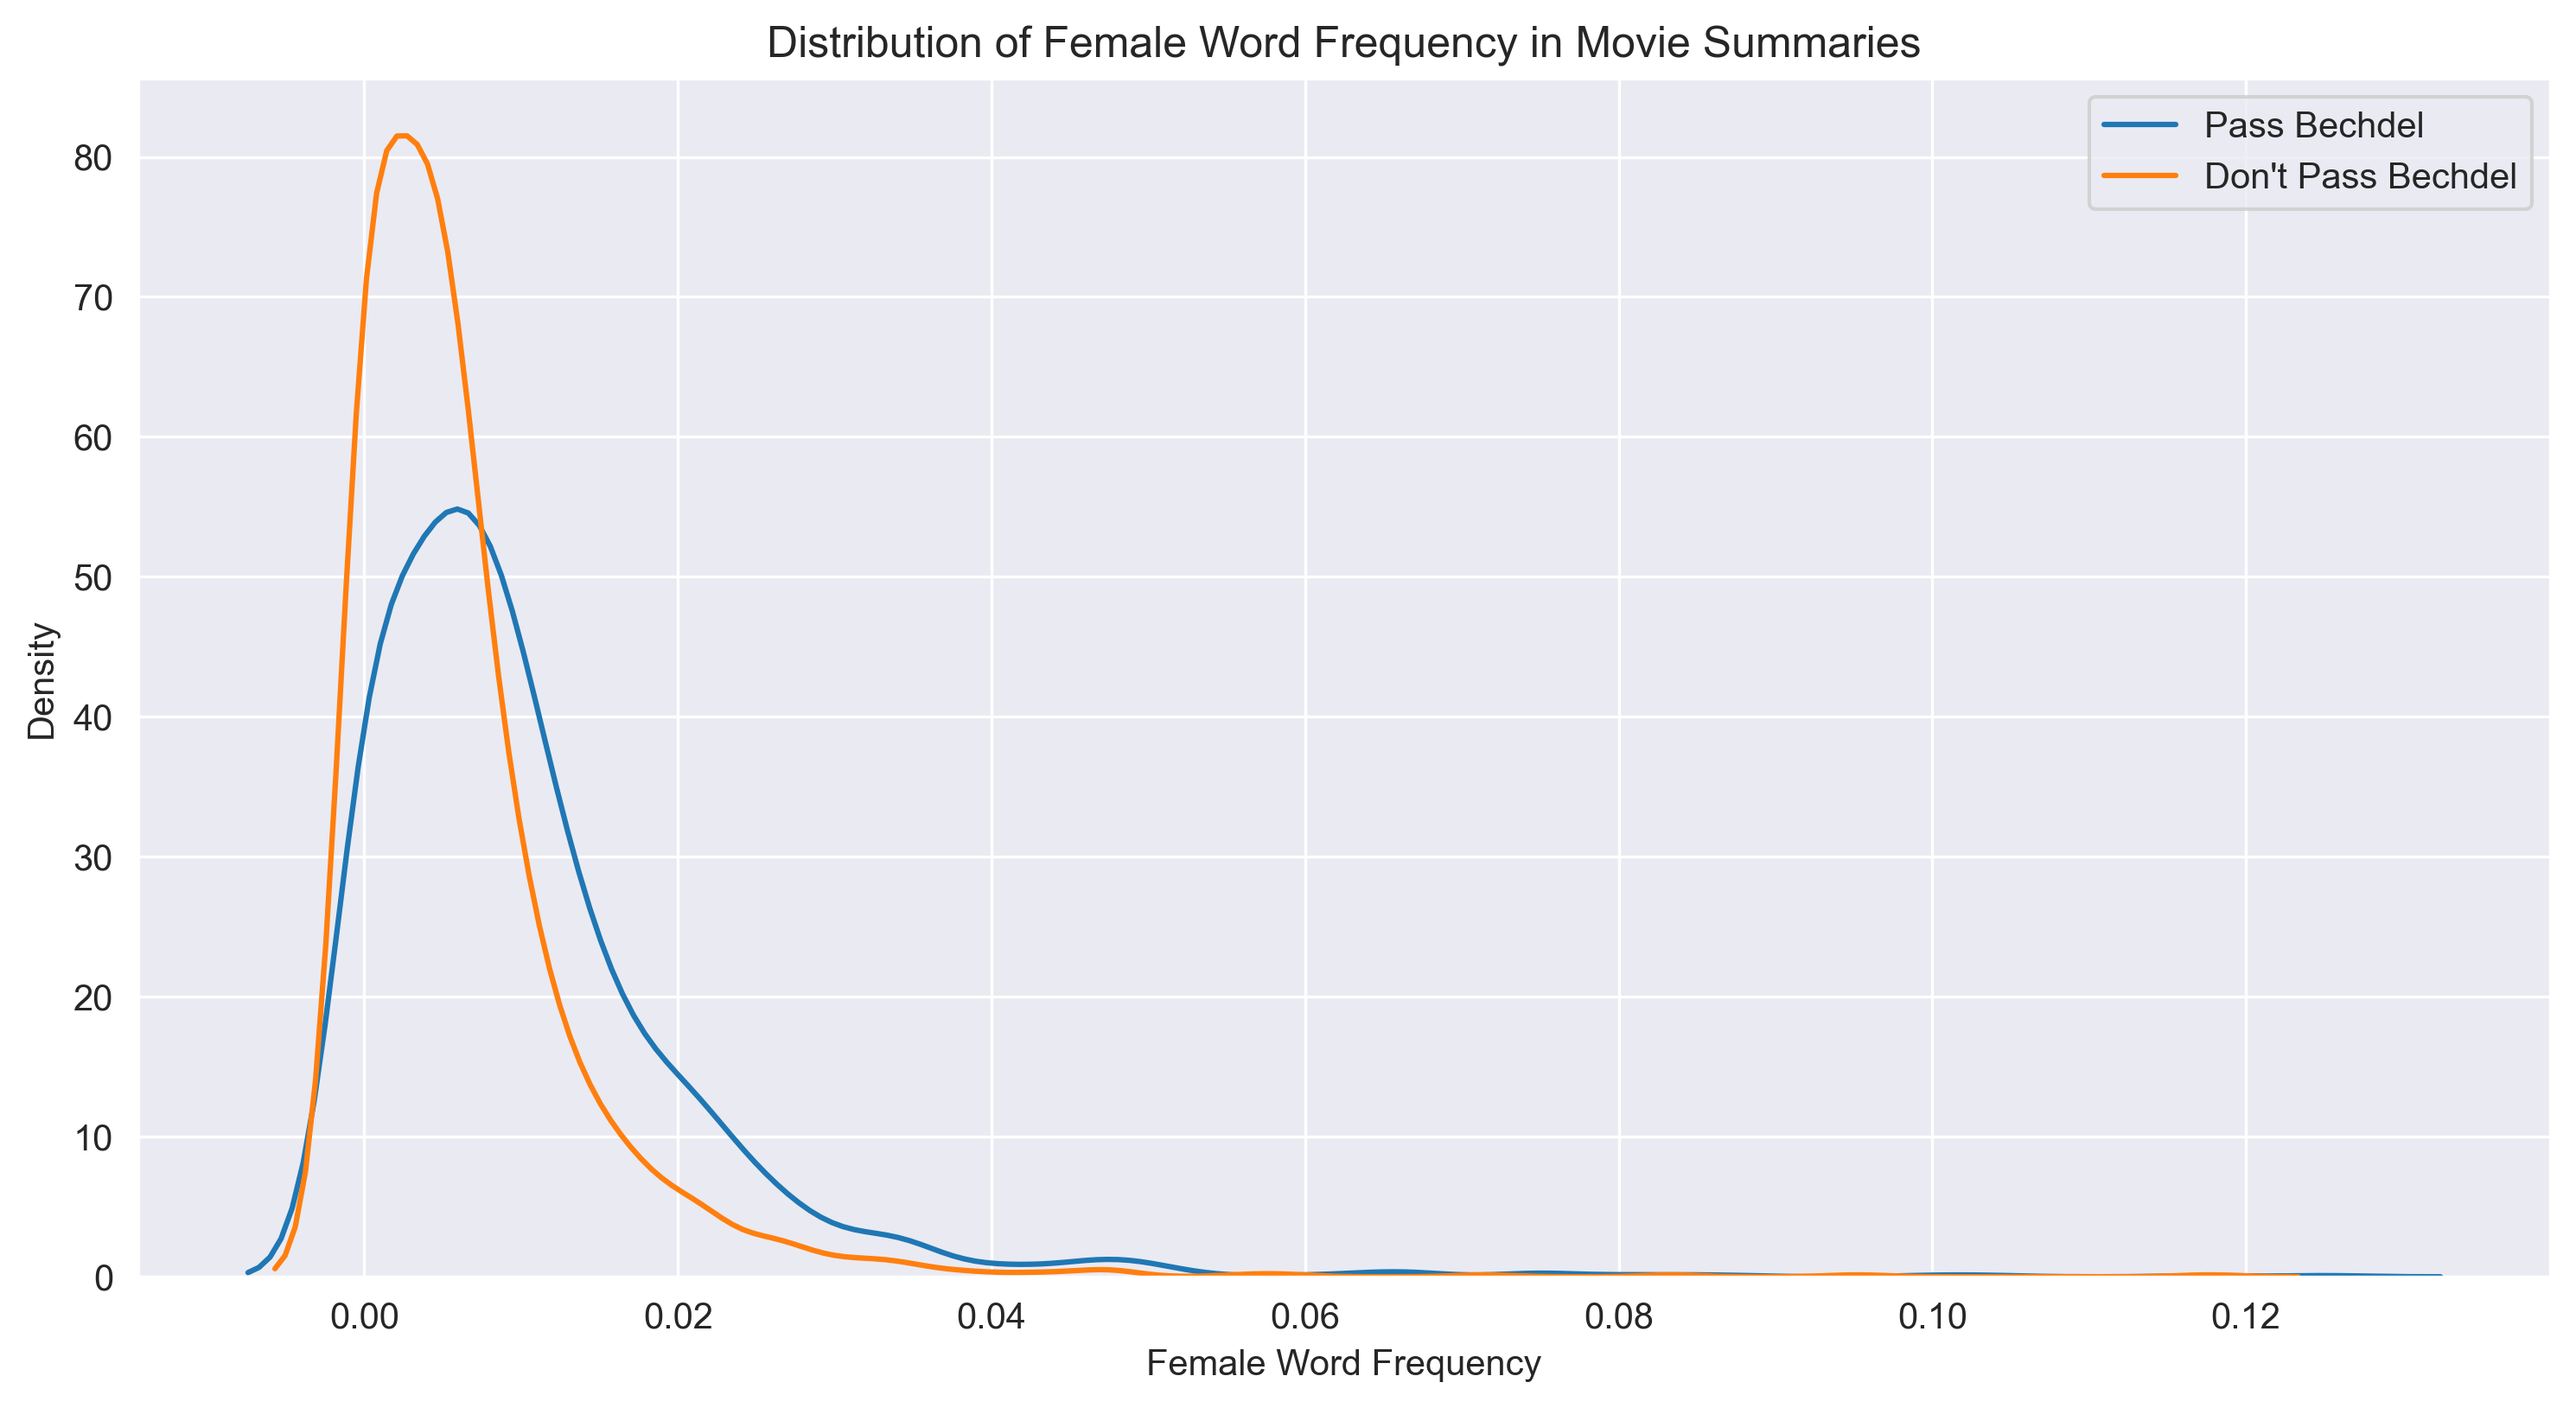

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Conducting the t-test on the female word frequency
t_stat, p_value = stats.ttest_ind(
    pass_bechdel_df["F word freq"], dont_pass_bechdel_df["F word freq"]
)

# Displaying the t-statistic and p-value
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Visualization
plt.figure(figsize=(12, 6))

# Plotting distributions
sns.distplot(pass_bechdel_df["F word freq"], label="Pass Bechdel", hist=False, kde=True)
sns.distplot(
    dont_pass_bechdel_df["F word freq"],
    label="Don't Pass Bechdel",
    hist=False,
    kde=True,
)

# Adding legend and titles
plt.legend()
plt.title("Distribution of Female Word Frequency in Movie Summaries")
plt.xlabel("Female Word Frequency")
plt.ylabel("Density")

plt.show()

**Interpretation**\
Given the high T-Statistic and the very low P-Value, you can reject the null hypothesis with a high degree of confidence. This means that the data strongly suggests there is a statistically significant difference in the frequency of female-specific vocabulary in movie summaries between movies that pass the Bechdel test and those that do not. Specifically, since the T-Statistic is positive, it indicates that movies that pass the Bechdel test have a higher frequency of female-specific vocabulary compared to movies that do not pass the test.

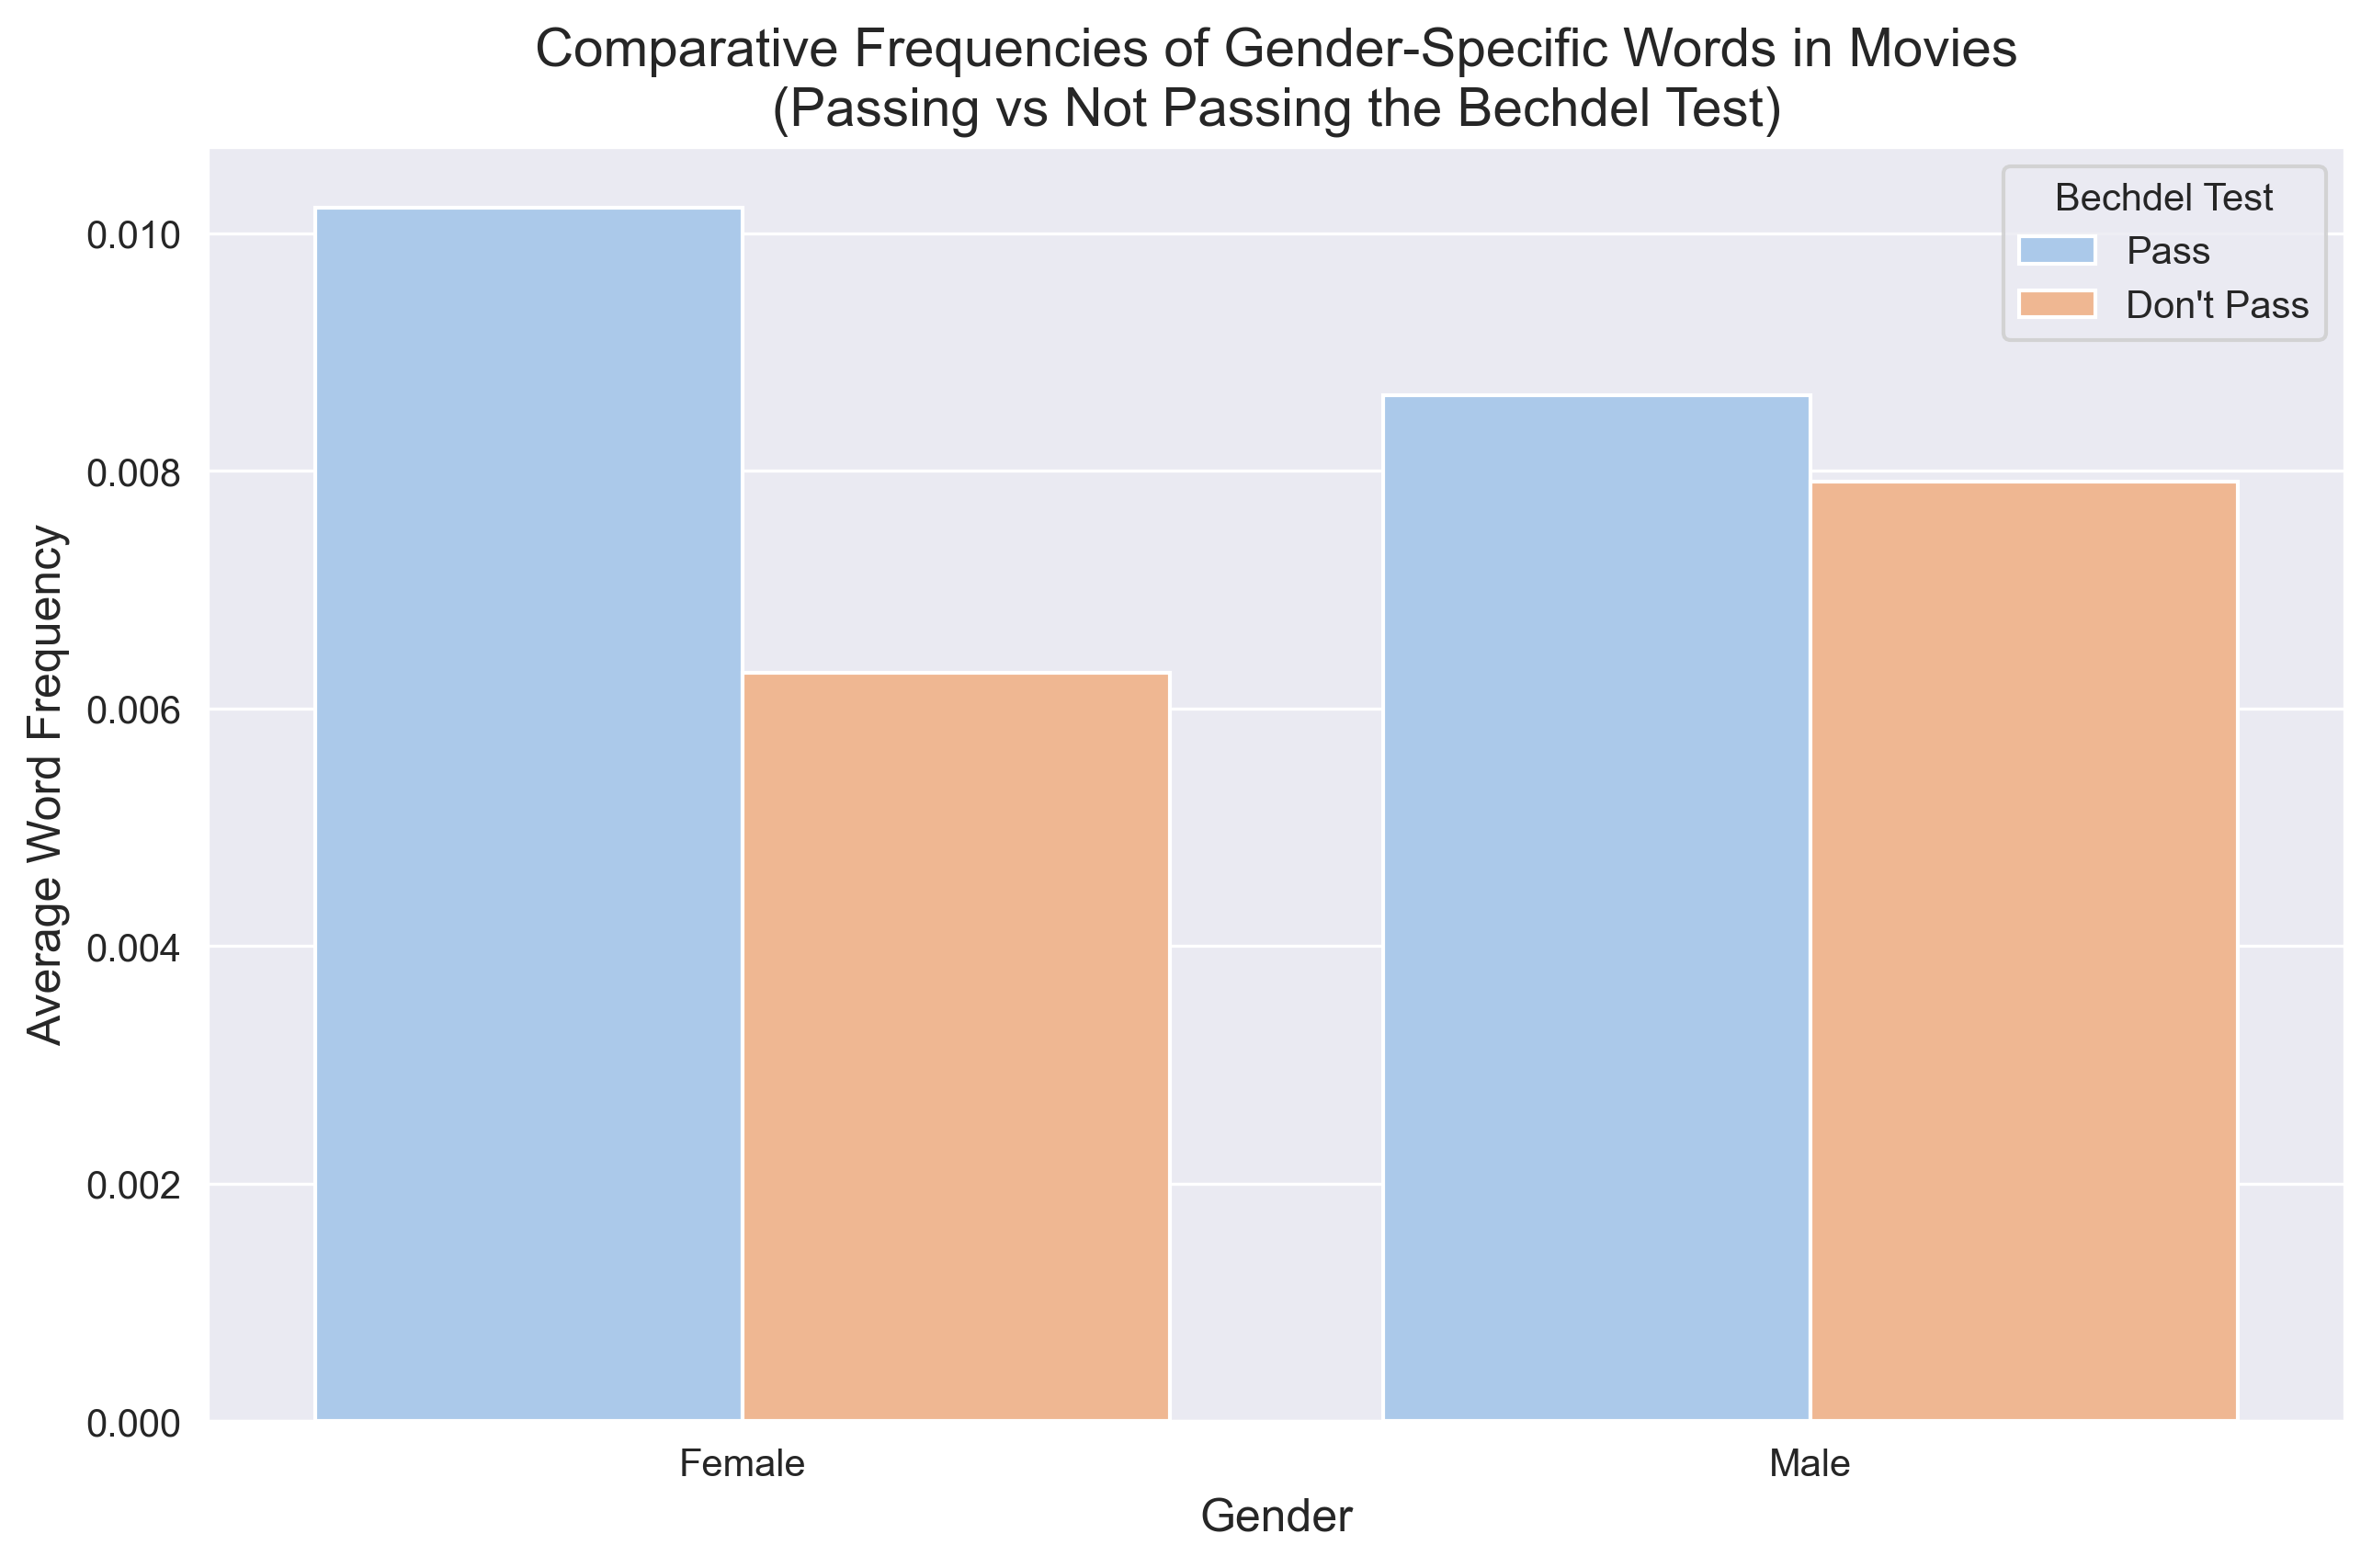

In [ ]:
# Calculate average frequencies
avg_freq_pass = pass_bechdel_df[["F word freq", "M word freq"]].mean()
avg_freq_dont_pass = dont_pass_bechdel_df[["F word freq", "M word freq"]].mean()

# Creating a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Gender": ["Female", "Male"] * 2,
        "Frequency": [
            avg_freq_pass["F word freq"],
            avg_freq_pass["M word freq"],
            avg_freq_dont_pass["F word freq"],
            avg_freq_dont_pass["M word freq"],
        ],
        "Bechdel": ["Pass", "Pass", "Don't Pass", "Don't Pass"],
    }
)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Gender", y="Frequency", hue="Bechdel", data=plot_data, palette="pastel")

# Adding titles and labels
plt.title(
    "Comparative Frequencies of Gender-Specific Words in Movies\n(Passing vs Not Passing the Bechdel Test)",
    fontsize=14,
)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Average Word Frequency", fontsize=12)
plt.legend(title="Bechdel Test")

# Display plot
plt.show()

## Sentiment analysis

### Breakdown
**Import Necessary Libraries:**
- from transformers import pipeline: Imports the pipeline function from the transformers library, which simplifies the process of using pre-trained models.
        
**Initialize the Sentiment Analysis Pipeline:**

sentiment_pipeline = pipeline("sentiment-analysis"): Initializes a sentiment analysis pipeline that automatically loads a pre-trained model suited for sentiment analysis (default is distilbert-base-uncased-finetuned-sst-2-english).



**Handle Maximum Token Limitation:**

Transformer models, like BERT, have a maximum token length (512 tokens for BERT). Longer texts need to be truncated or split to avoid indexing errors. One approach is to make the assumption that the main sentiment of the plot summary is well present in the first 512 tokens so we can truncate the plot summary.


**Batch Processing and Sentiment Analysis:**

Process plot summaries in batches to manage memory usage efficiently.
Each batch of truncated summaries is passed to the sentiment analysis pipeline, which outputs the sentiment classification ('POSITIVE' or 'NEGATIVE') and a confidence score for each summary.


In [ ]:
# Reload and reprocess the summary df
df_summaries2 = loader.load_summaries()
df_summaries2 = (
    pd.merge(df_summaries2, movies[["wikiID", "movie_title"]], on="wikiID", how="right")
    .drop_duplicates()
    .dropna(subset=["movie_title"])
)
df_summaries2["summary"] = df_summaries2["summary"].apply(clean_text)

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

ModuleNotFoundError: No module named 'transformers'

In [ ]:
# Test on a small subset of the summaries
plot_summaries = df_summaries2["summary"].tolist()
plot_summaries_test = df_summaries2["summary"].tolist()[:200]

In [ ]:
from transformers import DistilBertTokenizer

# Load the tokenizer for the DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Initialize the sentiments list
sentiments = []
batch_size = 10

for i in tqdm(range(0, len(plot_summaries_test), batch_size)):
    batch = plot_summaries[i : i + batch_size]
    # Truncate the summaries using the tokenizer
    truncated_batch = [
        tokenizer.decode(
            tokenizer.encode(summary, max_length=512, truncation=True),
            skip_special_tokens=True,
        )
        for summary in batch
    ]
    batch_sentiments = sentiment_pipeline(truncated_batch)
    sentiments.extend(batch_sentiments)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.67s/it]


sentiment
NEGATIVE    177
POSITIVE     23
Name: count, dtype: int64


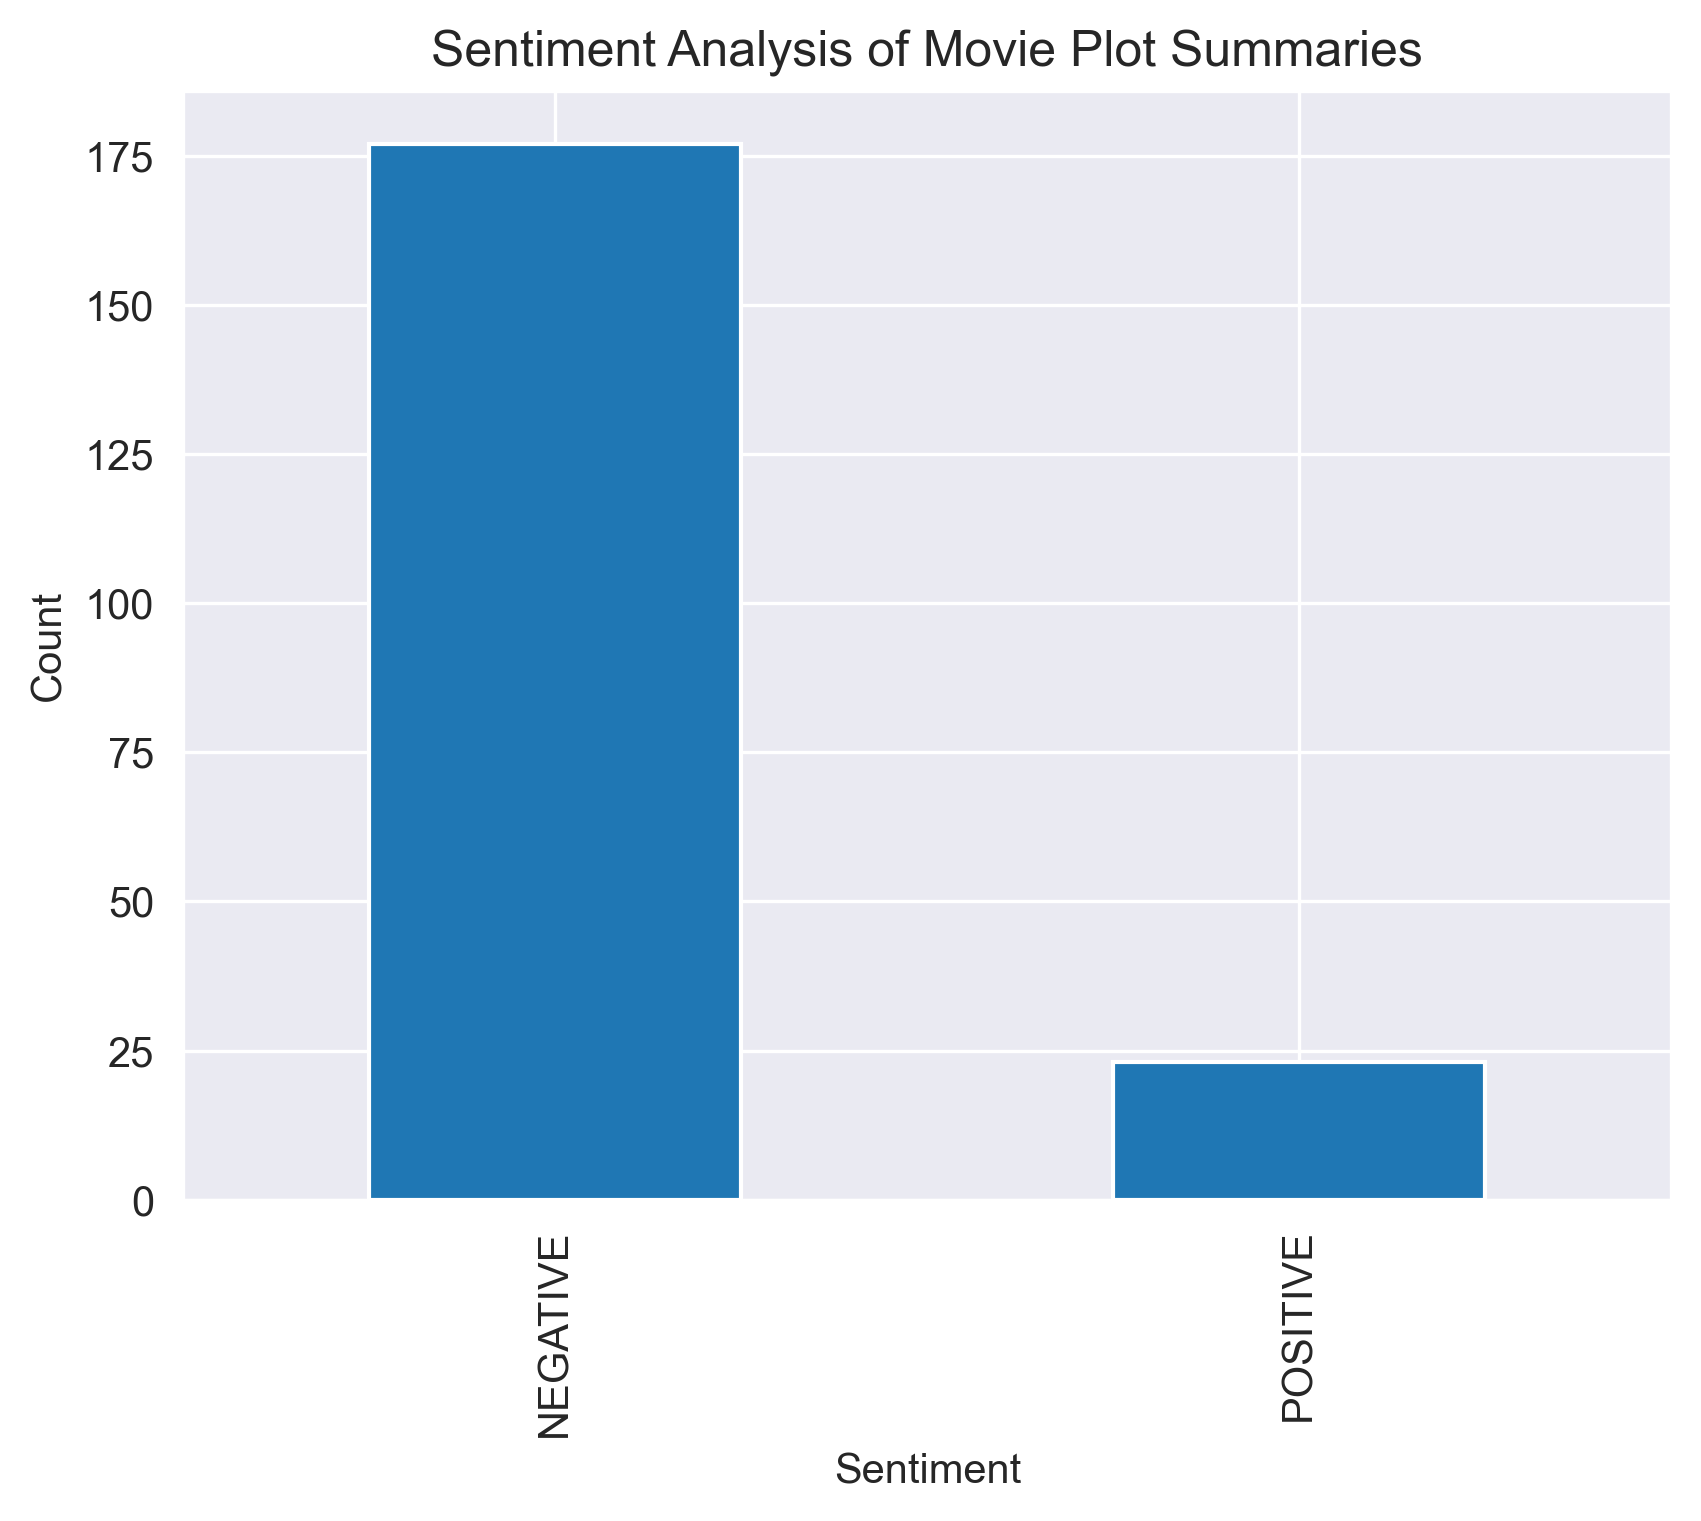

In [ ]:
df_summaries2_test = df_summaries2.copy(deep=True)
df_summaries2_test = df_summaries2_test.head(200)

# Add the sentiment results to your dataframe
df_summaries2_test["sentiment"] = [item["label"] for item in sentiments]
df_summaries2_test["sentiment_score"] = [item["score"] for item in sentiments]

# Example: Count the number of positive and negative summaries
sentiment_counts = df_summaries2_test["sentiment"].value_counts()
print(sentiment_counts)

# Visualizing the sentiment distribution
sentiment_counts.plot(kind="bar")
plt.title("Sentiment Analysis of Movie Plot Summaries")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()